In [1]:
# add open ai secret key to the environment
import os, re
from secret import OPENAI_API_KEY
import spacy
from spacypdfreader.spacypdfreader import pdf_reader
from haystack import Pipeline, Document
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.converters import PyPDFToDocument
from haystack.components.preprocessors import DocumentCleaner
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.writers import DocumentWriter
from pathlib import Path

document_store = InMemoryDocumentStore()
pdf_path = './data/MASTER_TremfyaPM_08Nov2022_annotated.pdf'


 
def load_pdf_spacy(pdf_path):
    nlp = spacy.load('en_core_web_sm')
    doc = pdf_reader(pdf_path, nlp)
    return doc

spacy_doc = load_pdf_spacy(pdf_path)

docs = []
RE_EXCESS_NEWLINE = re.compile(r"\n(?=[a-z])") # A \n followed by a lowercase character

for p in range(1, spacy_doc._.page_range[1] + 1):
    docs.append(Document(
        content=RE_EXCESS_NEWLINE.sub("", spacy_doc._.page(p).text), 
        meta={
            'source': spacy_doc._.pdf_file_name,
            'page': p, 
            'title': 'Tremfya-PM'}))


In [2]:
splitter = DocumentSplitter(split_by='passage', split_length= 2, split_overlap=0)
final_docs = splitter.run(docs)
print("Initial number of pages: ", len(docs))
print("Final number of chunks: ", len(final_docs['documents']))

Initial number of pages:  47
Final number of chunks:  439


In [3]:
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.document_stores.types import DuplicatePolicy

doc_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
doc_embedder.warm_up()

docs_with_embeddings = doc_embedder.run(final_docs['documents'])
document_store.write_documents(docs_with_embeddings["documents"], policy=DuplicatePolicy.SKIP)

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

ID '778698d46e88271ca332d723c8d7444957ed495ac397ebb617f810afb97bb586' already exists
ID '28ec8c7fca36312ea29ee94ea5ec0424426e5e156bd6caa4d5db5c72a53b5bac' already exists
ID '28ec8c7fca36312ea29ee94ea5ec0424426e5e156bd6caa4d5db5c72a53b5bac' already exists


436

In [4]:
docs[30].content

'Some side effects are uncommon (may affect up to 1 in 100 people):\nstomach flu (gastroenteritis)\nherpes simplex infections (e.g. cold sores, genital herpes) \nfungal infections of the skin (e.g. athlete’s foot) \n\n\uf0b7\n\n\uf0b7\n\n\uf0b7\n\n\uf0b7\n\n\uf0b7\n\n\uf0b7\n\n\uf0b7\n\n\uf0b7 migraine\nyeast infections\nallergic reactions\nskin rash\ndecreased number of a type of white blood cell called neutrophils\n\nThese are not all the possible side effects you may feel when taking TREMFYA®/TREMFYA \nOne-Press®. If you experience any side effects not listed here, contact your healthcare professional. \n\nIf you have a troublesome symptom or side effect that is not listed here or becomes bad enough to interfere with your daily activities, talk to your healthcare professional.\n\nReporting Side Effects\n\nYou can report any suspected side effects associated with the use of health products to \nHealth Canada by:\n\n\uf0b7 Visiting the Web page on Adverse Reaction Reporting\n\n(https:

# Initialzing the Retrieval System




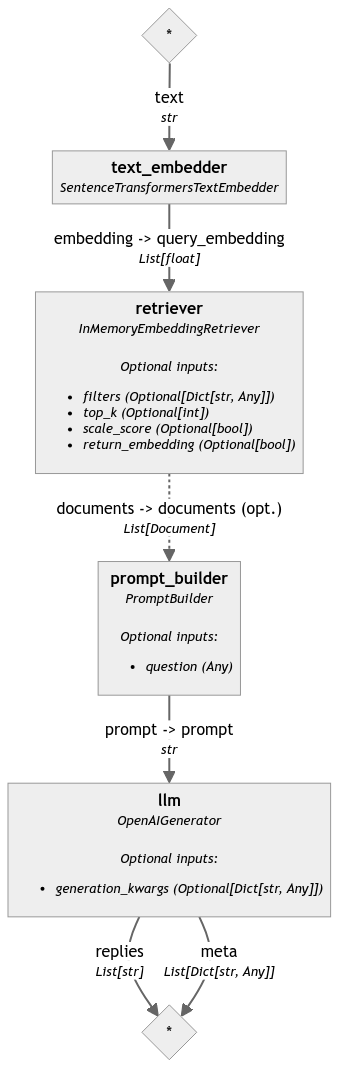

In [8]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import PromptBuilder
import os
from getpass import getpass
from haystack.components.generators import OpenAIGenerator

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
retriever = InMemoryEmbeddingRetriever(document_store=document_store)

template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=template)
generator = OpenAIGenerator(model="gpt-3.5-turbo")

basic_rag_pipeline = Pipeline()
# Add components to your pipeline
basic_rag_pipeline.add_component("text_embedder", text_embedder)
basic_rag_pipeline.add_component("retriever", retriever)
basic_rag_pipeline.add_component("prompt_builder", prompt_builder)
basic_rag_pipeline.add_component("llm", generator)

# Now, connect the components to each other
basic_rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
basic_rag_pipeline.connect("retriever", "prompt_builder.documents")
basic_rag_pipeline.connect("prompt_builder", "llm")

In [11]:
question = "What is the recommended dose of Tremfya for the treatment of plaque psoriasis? Please elaborate."

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

The recommended dose of Tremfya for the treatment of plaque psoriasis is 100 mg to be given as a subcutaneous injection every 8 weeks. This dosage regimen was used in clinical trials and has shown effectiveness in managing plaque psoriasis. It is important to follow this recommended dose and schedule for optimal results in treating the condition.


In [14]:
text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
retriever = InMemoryEmbeddingRetriever(document_store=document_store, top_k=5)
prompt_builder = PromptBuilder(template=template)

# test the output of retriver
basic_rag_pipeline = Pipeline()
# Add components to your pipeline
basic_rag_pipeline.add_component("text_embedder", text_embedder)
basic_rag_pipeline.add_component("retriever", retriever)
basic_rag_pipeline.add_component("prompt_builder", prompt_builder)
# basic_rag_pipeline.add_component("llm", generator)

# Now, connect the components to each other
basic_rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
basic_rag_pipeline.connect("retriever", "prompt_builder.documents")
# basic_rag_pipeline.connect("prompt_builder", "llm")

question = "What is the recommended dose of Tremfya for the treatment of plaque psoriasis? Please elaborate."
response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
print(response['prompt_builder']['prompt'])


Given the following information, answer the question.

Context:

    4.2 Recommended Dose and Dosage Adjustment

Plaque psoriasis
The recommended dose of TREMFYA®/TREMFYA One-Press® is 100 mg to be given as 



    Single intravenous doses of TREMFYA® up to 987 mg (10 mg/kg) have been administered in healthy volunteers and single subcutaneous doses of TREMFYA® up to 300 mg have been administered in patients with plaque psoriasis in clinical trials without dose-limiting toxicity. In the event of overdosage, monitor the patient for any signs or symptoms of adverse reactions and administer appropriate symptomatic treatment immediately.

For management of a suspected drug overdose, contact your regional Poison Control 
Centre.



    dosage regimen of 100 mg TREMFYA®/TREMFYA One-Press® as subcutaneous injection every 
8 weeks. In the phase 3 psoriatic arthritis trials 725 patients (including placebo crossovers) received a dosage regimen of 100 mg TREMFYA® as subcutaneous injection every 4